In [1]:
# Importación de librerías y supresión de warnings

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

In [2]:
# Cargar y explorar los datos

df = pd.read_csv("E:/UNAD/UNAD 2025/PRIMER SEMESTRE/ANALISIS DE DATOS/Tarea 4/Mall_Customers.csv")

df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Valores nulos por columna:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


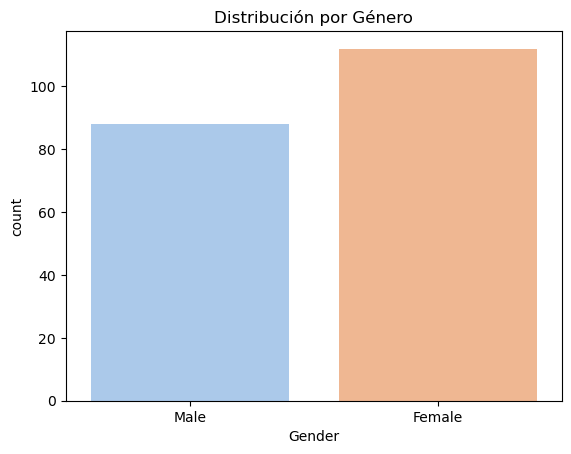

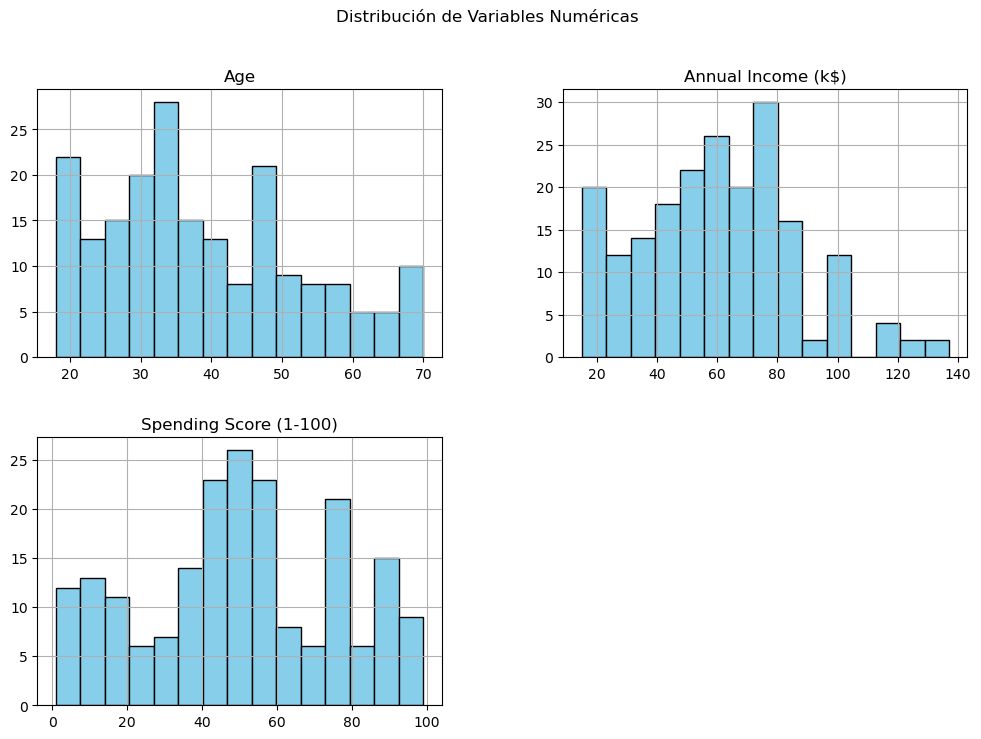

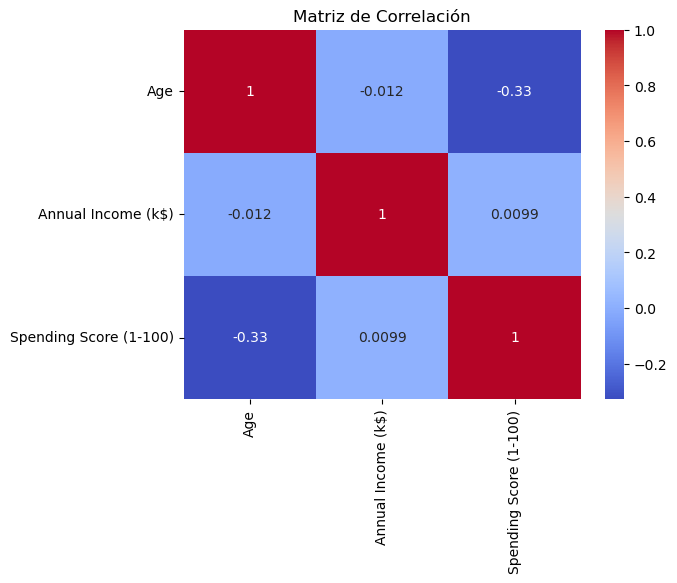

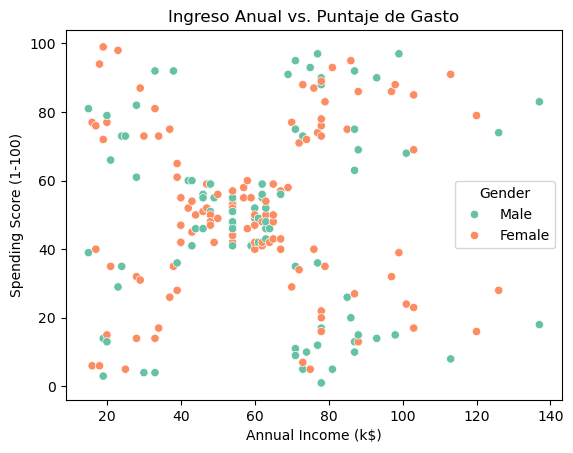

In [5]:
print("Valores nulos por columna:\n", df.isnull().sum())

sns.countplot(x='Gender', data=df, palette='pastel')
plt.title("Distribución por Género")
plt.show()

df.drop('CustomerID', axis=1).hist(bins=15, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de Variables Numéricas")
plt.show()

sns.heatmap(df.drop('CustomerID', axis=1).corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', palette='Set2')
plt.title("Ingreso Anual vs. Puntaje de Gasto")
plt.show()

In [7]:
# Preprocesamiento

df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df_clustering = df.drop('CustomerID', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Selección de dos variables más relevantes para clustering
X_selected = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X_scaled_sel = scaler.fit_transform(X_selected)

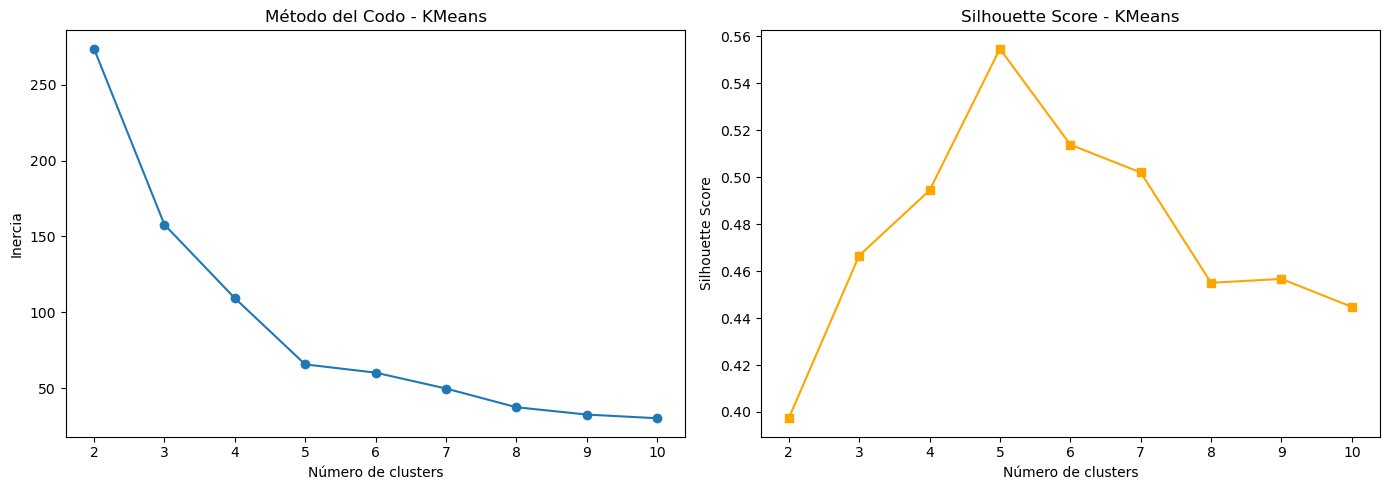

In [9]:
# Selección del número óptimo de clusters para KMeans

inertia = []
silhouette = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_sel)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_sel, labels))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Método del Codo - KMeans")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette, marker='s', color='orange')
plt.title("Silhouette Score - KMeans")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


--- Resultados para KMeans con k=4 ---
Coeficiente de Silhouette: 0.49434988482196784
Índice de Calinski-Harabasz: 173.9210611775394
Índice de Davies-Bouldin: 0.6974596547758415
Inercia: 109.22822707921344


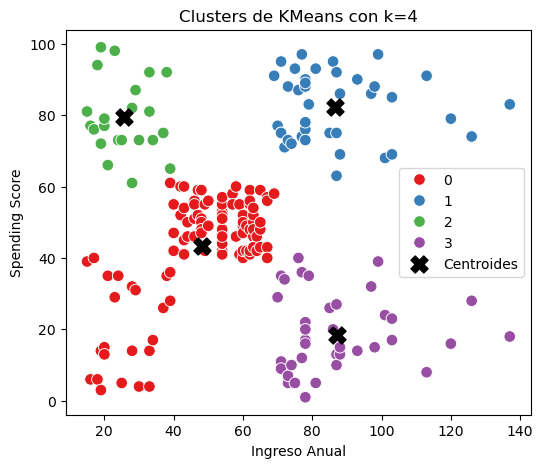


--- Resultados para KMeans con k=5 ---
Coeficiente de Silhouette: 0.5546571631111091
Índice de Calinski-Harabasz: 248.64932001536357
Índice de Davies-Bouldin: 0.5722356162263352
Inercia: 65.56840815571681


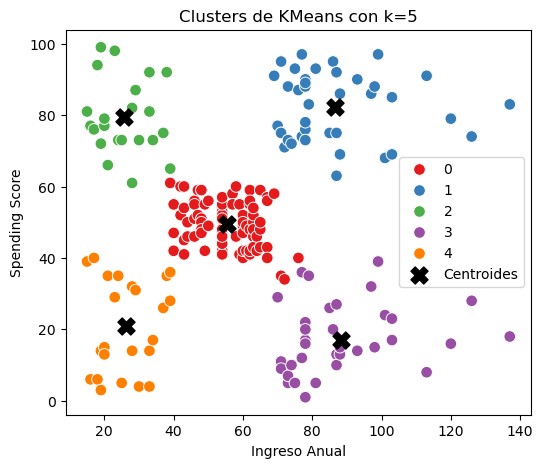

In [11]:
# Entrenamiento y evaluación para KMeans con k=4 y k=5

for k in [4, 5]:
    print(f"\n--- Resultados para KMeans con k={k} ---")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_sel)
    
    print("Coeficiente de Silhouette:", silhouette_score(X_scaled_sel, labels))
    print("Índice de Calinski-Harabasz:", calinski_harabasz_score(X_scaled_sel, labels))
    print("Índice de Davies-Bouldin:", davies_bouldin_score(X_scaled_sel, labels))
    print("Inercia:", kmeans.inertia_)

    # Gráfica de clusters y centroides
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=X_selected['Annual Income (k$)'], y=X_selected['Spending Score (1-100)'],
                    hue=labels, palette='Set1', s=70)
    
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0]*X_selected.std()[0] + X_selected.mean()[0], 
                centers[:, 1]*X_selected.std()[1] + X_selected.mean()[1], 
                c='black', s=150, marker='X', label='Centroides')
    
    plt.title(f"Clusters de KMeans con k={k}")
    plt.xlabel("Ingreso Anual")
    plt.ylabel("Spending Score")
    plt.legend()
    plt.show()

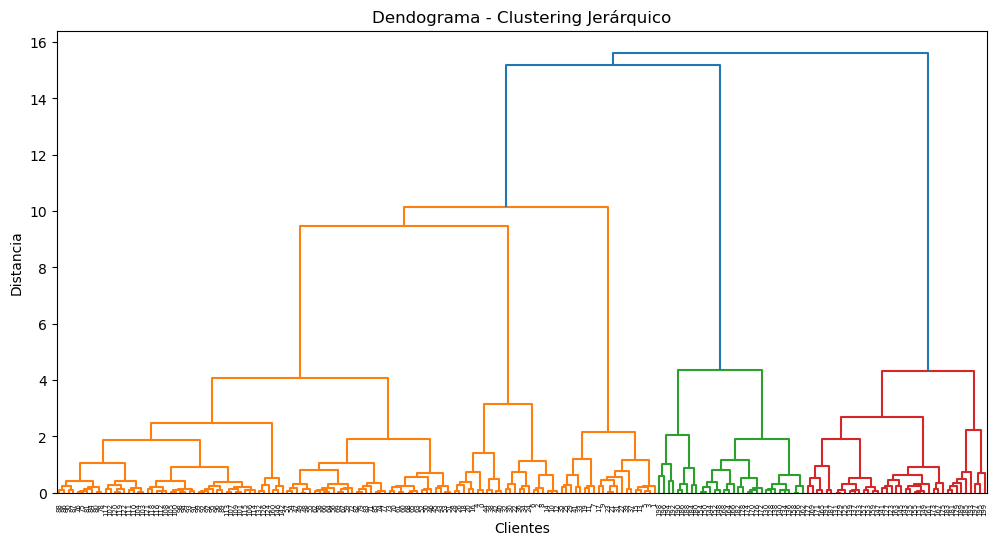

In [13]:
# Clustering Jerárquico - Dendograma y Silhouette

linked = linkage(X_scaled_sel, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Dendograma - Clustering Jerárquico")
plt.xlabel("Clientes")
plt.ylabel("Distancia")
plt.show()

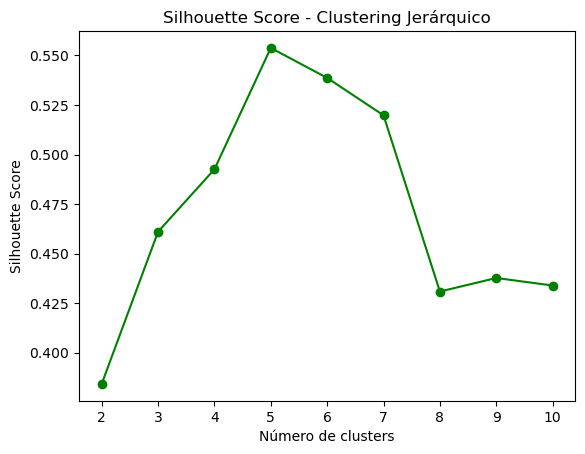

In [15]:
# Método del silhouette para elegir número de clusters

silhouette_scores = []
for k in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=k)
    labels = hc.fit_predict(X_scaled_sel)
    silhouette_scores.append(silhouette_score(X_scaled_sel, labels))

plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score - Clustering Jerárquico")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [17]:
# Evaluación de Clustering Jerárquico para k=3 y k=5

for k in [3, 5]:
    print(f"\n--- Resultados para Clustering Jerárquico con k={k} ---")
    hc = AgglomerativeClustering(n_clusters=k)
    labels = hc.fit_predict(X_scaled_sel)

    print("Coeficiente de Silhouette:", silhouette_score(X_scaled_sel, labels))
    print("Índice de Calinski-Harabasz:", calinski_harabasz_score(X_scaled_sel, labels))
    print("Índice de Davies-Bouldin:", davies_bouldin_score(X_scaled_sel, labels))



--- Resultados para Clustering Jerárquico con k=3 ---
Coeficiente de Silhouette: 0.4610481446570447
Índice de Calinski-Harabasz: 143.77956237851728
Índice de Davies-Bouldin: 0.7072871869794293

--- Resultados para Clustering Jerárquico con k=5 ---
Coeficiente de Silhouette: 0.5538089226688662
Índice de Calinski-Harabasz: 244.41032586596822
Índice de Davies-Bouldin: 0.5778621190740154


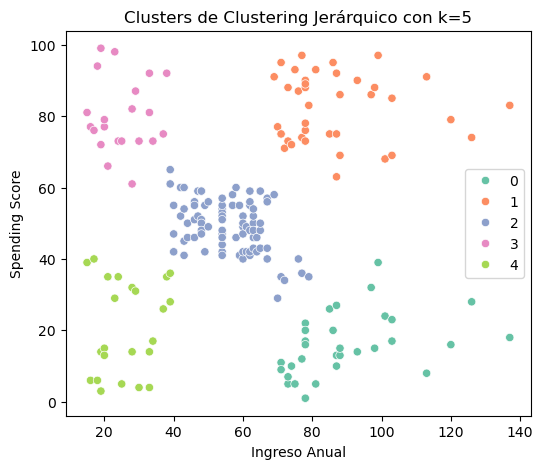

In [23]:
# Visualización

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_selected['Annual Income (k$)'], y=X_selected['Spending Score (1-100)'],
                hue=labels, palette='Set2')
plt.title(f"Clusters de Clustering Jerárquico con k={k}")
plt.xlabel("Ingreso Anual")
plt.ylabel("Spending Score")
plt.legend()
plt.show()

In [25]:
# Coeficiente de correlación cofenética

coph_corr, _ = cophenet(linked, pdist(X_scaled_sel))
print("\nCoeficiente de Correlación Cofenética:", coph_corr)


Coeficiente de Correlación Cofenética: 0.7209128193077099


# Conclusiones e Interpretación Final

- Entre 4 y 5 clusters parecen óptimos para KMeans según el método del codo y Silhouette.
- El modelo KMeans tiene mejor desempeño en separación y cohesión de clusters que el jerárquico.
- La visualización de centroides permite identificar perfiles de clientes bien diferenciados.
- El coeficiente cofenético del dendograma indica buena fidelidad de las distancias originales.
- Se recomienda usar KMeans con 5 clusters para segmentar los clientes del mall de manera efectiva.